## Visualization libraries & Imports

In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import cv2

# Import matplotlib libraries
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection
import matplotlib.patches as patches

# Some modules to display an animation using imageio.
import imageio
from IPython.display import HTML, display

import pandas as pd
from pathlib import Path
from pprint import pprint
from tqdm.notebook import tqdm

tqdm.pandas()

2023-03-28 18:50:38.031283: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-28 18:50:38.032878: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-28 18:50:38.072945: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-28 18:50:38.075113: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-28 18:50:38.726229: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

In [2]:
DATA_DIR = Path("data")
YOGA_DATASET_DIR = DATA_DIR / "yoga_dataset"
YOGA_POSES_DIR = YOGA_DATASET_DIR / "content"

INPUT_SIZE = 256

In [3]:
# Dictionary that maps from joint names to keypoint indices.
KEYPOINT_DICT = {
    'nose': 0,
    'left_eye': 1,
    'right_eye': 2,
    'left_ear': 3,
    'right_ear': 4,
    'left_shoulder': 5,
    'right_shoulder': 6,
    'left_elbow': 7,
    'right_elbow': 8,
    'left_wrist': 9,
    'right_wrist': 10,
    'left_hip': 11,
    'right_hip': 12,
    'left_knee': 13,
    'right_knee': 14,
    'left_ankle': 15,
    'right_ankle': 16
}

In [4]:
#@title Helper functions for visualization

# Maps bones to a matplotlib color name.
KEYPOINT_EDGE_INDS_TO_COLOR = {
    (0, 1): 'm',
    (0, 2): 'c',
    (1, 3): 'm',
    (2, 4): 'c',
    (0, 5): 'm',
    (0, 6): 'c',
    (5, 7): 'm',
    (7, 9): 'm',
    (6, 8): 'c',
    (8, 10): 'c',
    (5, 6): 'y',
    (5, 11): 'm',
    (6, 12): 'c',
    (11, 12): 'y',
    (11, 13): 'm',
    (13, 15): 'm',
    (12, 14): 'c',
    (14, 16): 'c'
}

def _keypoints_and_edges_for_display(keypoints_with_scores,
                                     height,
                                     width,
                                     keypoint_threshold=0.11):
  """Returns high confidence keypoints and edges for visualization.

  Args:
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    height: height of the image in pixels.
    width: width of the image in pixels.
    keypoint_threshold: minimum confidence score for a keypoint to be
      visualized.

  Returns:
    A (keypoints_xy, edges_xy, edge_colors) containing:
      * the coordinates of all keypoints of all detected entities;
      * the coordinates of all skeleton edges of all detected entities;
      * the colors in which the edges should be plotted.
  """
  keypoints_all = []
  keypoint_edges_all = []
  edge_colors = []
  num_instances, _, _, _ = keypoints_with_scores.shape
  for idx in range(num_instances):
    kpts_x = keypoints_with_scores[0, idx, :, 1]
    kpts_y = keypoints_with_scores[0, idx, :, 0]
    kpts_scores = keypoints_with_scores[0, idx, :, 2]
    kpts_absolute_xy = np.stack(
        [width * np.array(kpts_x), height * np.array(kpts_y)], axis=-1)
    kpts_above_thresh_absolute = kpts_absolute_xy[
        kpts_scores > keypoint_threshold, :]
    keypoints_all.append(kpts_above_thresh_absolute)

    for edge_pair, color in KEYPOINT_EDGE_INDS_TO_COLOR.items():
      if (kpts_scores[edge_pair[0]] > keypoint_threshold and
          kpts_scores[edge_pair[1]] > keypoint_threshold):
        x_start = kpts_absolute_xy[edge_pair[0], 0]
        y_start = kpts_absolute_xy[edge_pair[0], 1]
        x_end = kpts_absolute_xy[edge_pair[1], 0]
        y_end = kpts_absolute_xy[edge_pair[1], 1]
        line_seg = np.array([[x_start, y_start], [x_end, y_end]])
        keypoint_edges_all.append(line_seg)
        edge_colors.append(color)
  if keypoints_all:
    keypoints_xy = np.concatenate(keypoints_all, axis=0)
  else:
    keypoints_xy = np.zeros((0, 17, 2))

  if keypoint_edges_all:
    edges_xy = np.stack(keypoint_edges_all, axis=0)
  else:
    edges_xy = np.zeros((0, 2, 2))
  return keypoints_xy, edges_xy, edge_colors


def draw_prediction_on_image(
    image, keypoints_with_scores, crop_region=None, close_figure=False,
    output_image_height=None):
  """Draws the keypoint predictions on image.

  Args:
    image: A numpy array with shape [height, width, channel] representing the
      pixel values of the input image.
    keypoints_with_scores: A numpy array with shape [1, 1, 17, 3] representing
      the keypoint coordinates and scores returned from the MoveNet model.
    crop_region: A dictionary that defines the coordinates of the bounding box
      of the crop region in normalized coordinates (see the init_crop_region
      function below for more detail). If provided, this function will also
      draw the bounding box on the image.
    output_image_height: An integer indicating the height of the output image.
      Note that the image aspect ratio will be the same as the input image.

  Returns:
    A numpy array with shape [out_height, out_width, channel] representing the
    image overlaid with keypoint predictions.
  """
  height, width, channel = image.shape
  aspect_ratio = float(width) / height
  fig, ax = plt.subplots(figsize=(12 * aspect_ratio, 12))
  # To remove the huge white borders
  fig.tight_layout(pad=0)
  ax.margins(0)
  ax.set_yticklabels([])
  ax.set_xticklabels([])
  plt.axis('off')

  im = ax.imshow(image)
  line_segments = LineCollection([], linewidths=(4), linestyle='solid')
  ax.add_collection(line_segments)
  # Turn off tick labels
  scat = ax.scatter([], [], s=60, color='#FF1493', zorder=3)

  (keypoint_locs, keypoint_edges,
   edge_colors) = _keypoints_and_edges_for_display(
       keypoints_with_scores, height, width)

  line_segments.set_segments(keypoint_edges)
  line_segments.set_color(edge_colors)
  if keypoint_edges.shape[0]:
    line_segments.set_segments(keypoint_edges)
    line_segments.set_color(edge_colors)
  if keypoint_locs.shape[0]:
    scat.set_offsets(keypoint_locs)

  if crop_region is not None:
    xmin = max(crop_region['x_min'] * width, 0.0)
    ymin = max(crop_region['y_min'] * height, 0.0)
    rec_width = min(crop_region['x_max'], 0.99) * width - xmin
    rec_height = min(crop_region['y_max'], 0.99) * height - ymin
    rect = patches.Rectangle(
        (xmin,ymin),rec_width,rec_height,
        linewidth=1,edgecolor='b',facecolor='none')
    ax.add_patch(rect)

  fig.canvas.draw()
  image_from_plot = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
  image_from_plot = image_from_plot.reshape(
      fig.canvas.get_width_height()[::-1] + (3,))
  plt.close(fig)
  if output_image_height is not None:
    output_image_width = int(output_image_height / height * width)
    image_from_plot = cv2.resize(
        image_from_plot, dsize=(output_image_width, output_image_height),
         interpolation=cv2.INTER_CUBIC)
  return image_from_plot

## Load Model from TF hub

In [5]:
module = hub.load("https://tfhub.dev/google/movenet/singlepose/thunder/4")
model = module.signatures['serving_default']

2023-03-28 18:50:40.482013: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-03-28 18:50:40.520182: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [6]:
def _img_as_input(img_path, img_format, input_size):
    image = tf.io.read_file(str(img_path))
    # Decode the image based on the image format.
    if img_format.lower() == 'jpeg':
        image = tf.image.decode_jpeg(image, channels=3)
    elif img_format.lower() == 'png':
        image = tf.image.decode_png(image, channels=3)
    else:
        print(f"Warning: {img_format} format not supported. Decoding as jpeg.")
        image = tf.image.decode_jpeg(image, channels=3)

    # Resize and pad the image to keep the aspect ratio and fit the expected size.
    input_image = tf.expand_dims(image, axis=0)
    input_image = tf.image.resize_with_pad(input_image, input_size, input_size)

    # SavedModel format expects tensor type of int32.
    input_image = tf.cast(input_image, dtype=tf.int32)
    return input_image


def _process_single_image(model, img_path, img_format, input_size):
    input_image = _img_as_input(img_path, img_format, input_size)
    # Run model inference.
    outputs = model(input_image)
    # Output is a [1, 1, 17, 3] tensor, cords and scores of 17 keypoints.
    keypoints_with_scores = outputs['output_0'].numpy()
    return keypoints_with_scores


def _display_pose(keypoints_with_scores, img_path, img_format, display_size=1280, figsize=(5,5)):
    display_image = _img_as_input(img_path, img_format, display_size)

    # Visualize the predictions with image.
    output_overlay = draw_prediction_on_image(
        np.squeeze(display_image.numpy(), axis=0),
        keypoints_with_scores
    )

    plt.figure(figsize=figsize)
    plt.imshow(output_overlay)
    _ = plt.axis('off')

## Single image prediction example

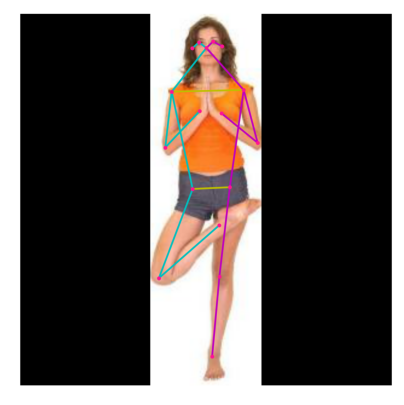

In [7]:
img_path = YOGA_POSES_DIR / "vriksasana/30-0.png"
img_format = "PNG"

keypoints_with_scores = _process_single_image(model, img_path, img_format, INPUT_SIZE)

_display_pose(keypoints_with_scores, img_path, img_format)

In [8]:
pprint(keypoints_with_scores)

array([[[[0.09119736, 0.5010747 , 0.5407492 ],
         [0.07384965, 0.5191677 , 0.7866914 ],
         [0.0759275 , 0.48084843, 0.7349202 ],
         [0.08693121, 0.54372525, 0.80505764],
         [0.09220451, 0.46333236, 0.7575611 ],
         [0.20433834, 0.60157996, 0.9276728 ],
         [0.20904766, 0.40768874, 0.72325635],
         [0.34672233, 0.6391656 , 0.80089056],
         [0.35932365, 0.3904228 , 0.89544755],
         [0.26698261, 0.54161066, 0.5949157 ],
         [0.26163638, 0.482845  , 0.7549929 ],
         [0.46634522, 0.5642695 , 0.89806986],
         [0.47100386, 0.4641787 , 0.92412555],
         [0.70736486, 0.53611934, 0.8315767 ],
         [0.71122885, 0.37318462, 0.84877783],
         [0.9222515 , 0.51658607, 0.88228697],
         [0.5686346 , 0.5360149 , 0.67653614]]]], dtype=float32)


In [9]:
df_metadata = pd.read_csv(YOGA_DATASET_DIR / "metadata.csv")
df_metadata.head()

,pose,filename,format,width,height
0,hanumanasana,3-0.png,PNG,440,299
1,hanumanasana,21-0.png,PNG,466,453
2,hanumanasana,45-0.png,PNG,397,228
3,hanumanasana,67-0.png,PNG,493,402
4,hanumanasana,25-0.png,PNG,518,336


In [10]:
def _handle_metadata_row(row, model, yoga_poses_dir: Path, input_size: int, keypoint_dict: dict):
    img_path = yoga_poses_dir / row["pose"] / row["filename"]
    keypoints_with_scores = _process_single_image(model, img_path, row["format"], input_size)
    # _display_pose(keypoints_with_scores, img_path, row["format"])
    for keypoint in keypoint_dict:
        kp_x, kp_y, kp_score = keypoints_with_scores[0][0][keypoint_dict[keypoint]]
        row[f"{keypoint}_x"] = kp_x
        row[f"{keypoint}_y"] = kp_y
        row[f"{keypoint}_score"] = kp_score
    return row

In [13]:
df = df_metadata.progress_apply(_handle_metadata_row, args=(model, YOGA_POSES_DIR, INPUT_SIZE, KEYPOINT_DICT), axis=1)
df.head()

  0%|          | 0/5994 [00:00<?, ?it/s]

2023-03-28 18:53:02.514637: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 18:53:16.406287: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile


2023-03-28 18:55:09.561420: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 18:55:10.649429: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: iCCP: known incorrect sRGB profile
2023-03-28 18:55:12.903259: W tensorflow/core/lib/png/png_io.cc:88] PNG warning: cHRM: inconsistent chromaticities


,pose,filename,format,width,height,nose_x,nose_y,nose_score,left_eye_x,left_eye_y,...,left_knee_score,right_knee_x,right_knee_y,right_knee_score,left_ankle_x,left_ankle_y,left_ankle_score,right_ankle_x,right_ankle_y,right_ankle_score
0,hanumanasana,3-0.png,PNG,440,299,0.261698,0.512255,0.630277,0.237344,0.517355,...,0.720410,0.722782,0.674401,0.858969,0.683820,0.050615,0.601454,0.795440,0.924660,0.741907
1,hanumanasana,21-0.png,PNG,466,453,0.394864,0.491497,0.831882,0.370693,0.487102,...,0.849817,0.805349,0.174530,0.807741,0.908731,0.943022,0.840723,0.702517,0.003883,0.777568
2,hanumanasana,45-0.png,PNG,397,228,0.430713,0.753430,0.800470,0.439265,0.780632,...,0.298566,0.719260,0.579058,0.182867,0.728648,0.731057,0.359210,0.723543,0.732710,0.500341
3,hanumanasana,67-0.png,PNG,493,402,0.369197,0.440116,0.678368,0.368485,0.460600,...,0.868513,0.786196,0.241361,0.973960,0.854160,0.963011,0.850752,0.808341,0.036816,0.808559
4,hanumanasana,25-0.png,PNG,518,336,0.262922,0.548760,0.764848,0.245587,0.531681,...,0.888956,0.755988,0.298930,0.832813,0.741362,0.910159,0.891368,0.699116,0.092350,0.673872


In [19]:
df.memory_usage(deep=True).sum()

3732742

In [20]:
df.to_csv(DATA_DIR / "yoga_ds_with_keypoints.csv", index=False)